In [2]:
import pandas as pd
import numpy as np
df = pd.read_json("250k.docs.jsonl", lines=True)

In [3]:
df.columns

Index(['PaperId', 'Title', 'Rank', 'CitationCount', 'Doi', 'DocType',
       'BookTitle', 'Volume', 'Issue', 'FirstPage', 'LastPage',
       'PublishedDate', 'Publisher', 'Journal', 'Authors', 'FieldsOfStudy',
       'Urls', 'PdfUrl', 'Abstract'],
      dtype='object')

In [4]:
df.DocType.unique()

array(['Journal', 'Book', 'Patent', 'Conference', None], dtype=object)

In [5]:
papers = df[(df.DocType == "Journal") | (df.DocType == "Conference")]

In [6]:
papers.columns

Index(['PaperId', 'Title', 'Rank', 'CitationCount', 'Doi', 'DocType',
       'BookTitle', 'Volume', 'Issue', 'FirstPage', 'LastPage',
       'PublishedDate', 'Publisher', 'Journal', 'Authors', 'FieldsOfStudy',
       'Urls', 'PdfUrl', 'Abstract'],
      dtype='object')

In [7]:
papers["FirstPage"] = papers.FirstPage.apply(lambda x: x.split("-")[-1] if x else np.nan)

In [8]:
papers["LastPage"] = papers.LastPage.apply(lambda x: x.split("-")[-1] if x else np.nan)

In [9]:
papers["Length"] = pd.to_numeric(papers.LastPage) - pd.to_numeric(papers.FirstPage)

In [10]:
papers = papers.drop(columns=["Urls", "PdfUrl", "Doi", "Volume", "Issue", "FirstPage", "LastPage", "BookTitle", "PaperId"])

In [11]:
papers.iloc[0].Authors

[{'Name': 'F. Motoyoshi', 'AuthorId': '2632896860', 'SequenceNumber': 1},
 {'Name': 'N. Oshima', 'AuthorId': '2708987407', 'SequenceNumber': 2}]

In [12]:
papers.iloc[0].FieldsOfStudy

[{'Name': 'tobacco mosaic virus', 'Level': 3},
 {'Name': 'virus', 'Level': 2},
 {'Name': 'protoplast', 'Level': 2},
 {'Name': 'virology', 'Level': 1},
 {'Name': 'botany', 'Level': 1},
 {'Name': 'biology', 'Level': 0}]

In [13]:
authors = set()
for i, row in papers.iterrows():
    for entry in row.Authors:
        authors.add(entry["AuthorId"])

In [14]:
len(authors)

533118

In [15]:
major_fields = set()
no_major_fields = set()
minor_fields = set()
topics = set()
problems = set()
for i, row in papers.iterrows():
    major_amount = 0
    for entry in row.FieldsOfStudy:
        if entry["Level"] == 0:
            major_fields.add(entry["Name"])
            major_amount += 1
        elif entry["Level"] == 1:
            minor_fields.add(entry["Name"])
        elif entry["Level"] == 2:
            topics.add(entry["Name"])
        else:
            problems.add(entry["Name"])
    no_major_fields.add(major_amount)

In [16]:
print(f"Major Fields: {len(major_fields)}, Amounts: {no_major_fields}")
print(f"Minor Fields: {len(minor_fields)}")
print(f"Topics: {len(topics)}")
print(f"Problems: {len(problems)}")

Major Fields: 19, Amounts: {0, 1, 2, 3}
Minor Fields: 294
Topics: 28274
Problems: 49262


In [17]:
majors = []
minors = []
journals = []
for i, row in papers.iterrows():
    major_fields = []
    minor_fields = []
    journal_entry = row.Journal
    for entry in row.FieldsOfStudy:
        level = entry["Level"]
        name = entry["Name"]
        if level == 0:
            major_fields.append(name)
        elif level == 1:
            minor_fields.append(name)
    majors.append(major_fields)
    minors.append(minor_fields)
    journals.append(journal_entry["JournalName"] if journal_entry else np.nan)
    
papers["MajorFields"] = majors
papers["MinorFields"] = minors
papers["Journal"] = journals

In [18]:
papers = papers.drop(columns=["Authors", "FieldsOfStudy", "PublishedDate"])[papers.MajorFields.apply(lambda x: len(x)) == 1]

In [19]:
papers["MajorFields"] = papers.MajorFields.apply(lambda x: x[0])

<AxesSubplot:xlabel='% Total', ylabel='MajorFields'>

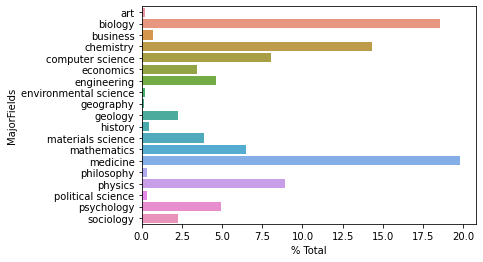

In [20]:
import seaborn as sns
sns.barplot(x=papers.groupby("MajorFields").count()["Title"].rename("% Total") /  papers.shape[0] * 100, y=papers.groupby("MajorFields").count().index)

<AxesSubplot:xlabel='Total', ylabel='MajorFields'>

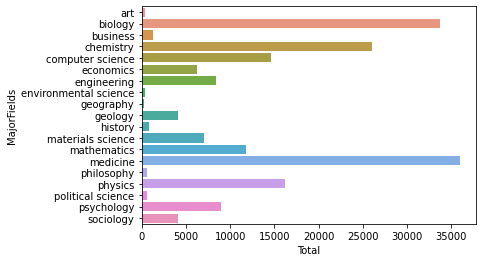

In [21]:
sns.barplot(x=papers.groupby("MajorFields").count()["Title"].rename("Total"), y=papers.groupby("MajorFields").count().index)

In [22]:
papers.head(4)

PaperId                                              Title   Rank  \
0  2013265920  Infection with Tobacco Mosaic Virus of Leaf Me...  22568   
2  2013266099  An indigenous cluster beam apparatus with a re...  21730   
5  2013266397  Determination of Plasma Dexamethasone in the M...  22203   
6  2013266476                                    Women and radio  22912   

   CitationCount  DocType                   Publisher  \
0            101  Journal        Microbiology Society   
2              6  Journal  Indian Academy of Sciences   
5             76  Journal       The Endocrine Society   
6             16  Journal                    Pergamon   

                                             Journal  \
0                        Journal of General Virology   
2                       Journal of Chemical Sciences   
5  The Journal of Clinical Endocrinology and Meta...   
6            Women's Studies International Quarterly   

                                            Abstract  Length MajorFields  \
0  Summary\nA procedure was developed to isolate ...    10.0     biology   
2  The design and fabrication of a Smalley-type c...    12.0   chemistry   
5  A RIA method is described for the measurement ...     6.0    medicine   
6  Synopsis   The relationship between women and ...    13.0   sociology   

                                         MinorFields  
0                                 [virology, botany]  
2  [analytical chemistry, nuclear magnetic resona...  
5                 [endocrinology, internal medicine]  
6                                      [advertising]